will be looking at classification
final layer will be (1, n_classes)
the output now will be a (n_classes, 1) logit, that has n_classes values
we have to softmax this to produce probabilities that sum correctly
CrossEntropyLoss will do this internally
cross entropy calclates -ln(pi) for prob predicted of what the true class is
if p(true class) is small this is punished, and if p(true class) = 1, this is 0. 

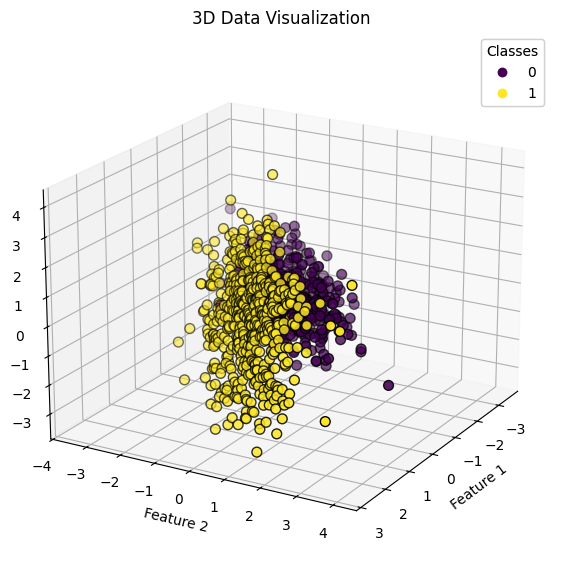

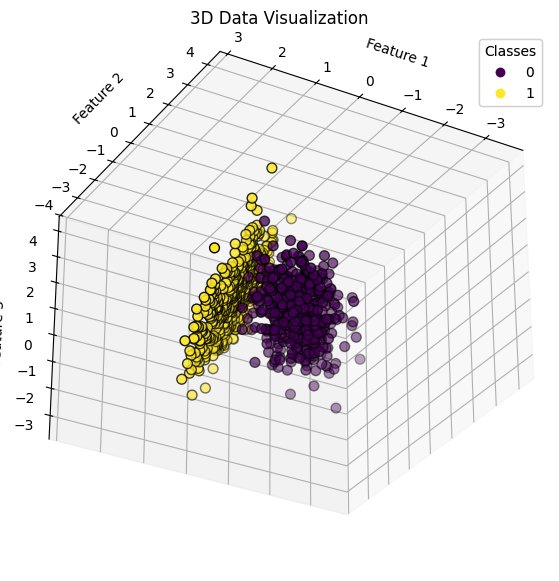

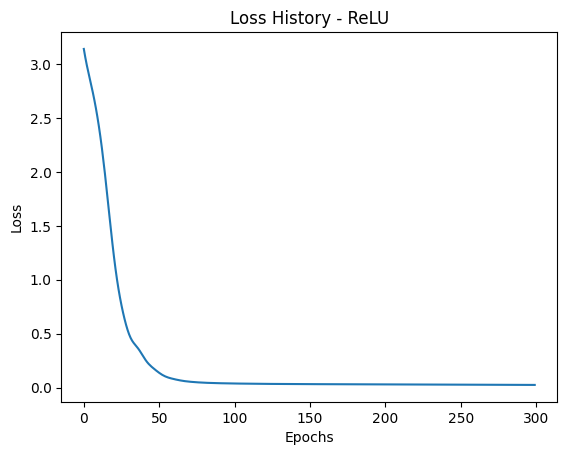

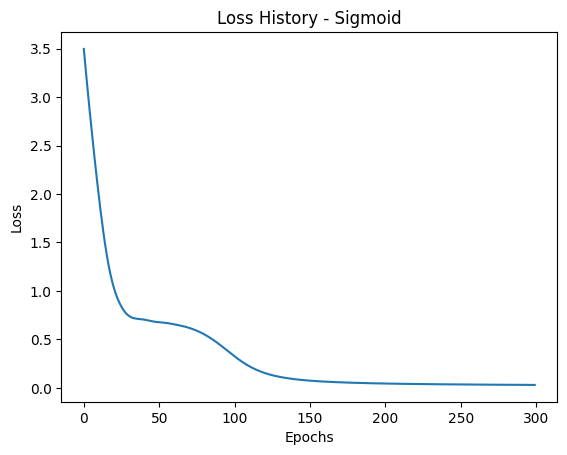

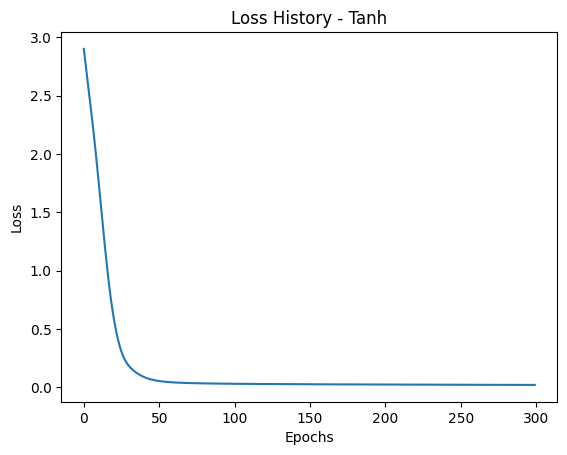

ReLU Activation Function: Loss: 0.024468569085001945, Accuracy: 0.985
Sigmoid Activation Function: Loss: 0.030024273321032524, Accuracy: 0.985
Tanh Activation Function: Loss: 0.021316982805728912, Accuracy: 0.99


TypeError: Input z must be 2D, not 3D

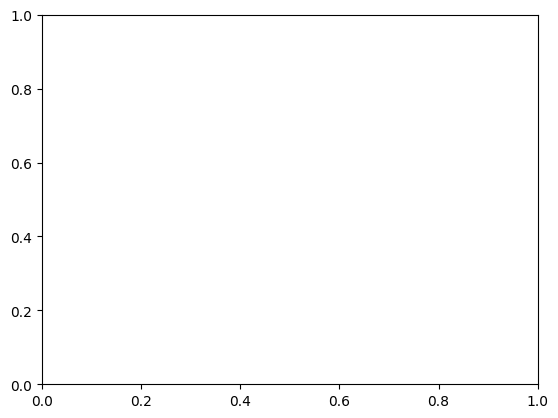

In [ ]:
import torch
import torch.nn as nn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, y =  make_classification(n_samples=1000, n_features=3, n_informative = 3, n_redundant = 0, n_classes=2, n_clusters_per_class = 1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

from mpl_toolkits.mplot3d import Axes3D

def plot_3d_data(X, y, title = "3D Data Visualization", elev=20, azim=30):
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111, projection='3d')   #111 short for 1 row, 1 column, 1st subplot, projection tells it the plot should be 3d

    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', edgecolor='k', s=50)
    #scatter then contains the metadata to access later
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    ax.view_init(elev=elev, azim=azim)  # Set the viewing angle

    legend = ax.legend(*scatter.legend_elements(), title = "Classes")
    ax.add_artist(legend)
    #scatter.legend_elements() returns (handles, labels)
    #ax.legend(handles, labels) is how to add a legend to the plot
    #so ax.legend(*scatter.legend_elements()) is a shorthand for the above
    #the * unpacks the tuple into two arguments for the ax.legend function

    plt.show()

plot_3d_data(X, y)
plot_3d_data(X, y, elev = -30, azim = 60)


class NN_classification(nn.Module):
    def __init__(self, input_dim, output_dim, activation_fn = nn.ReLU()):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer1 = nn.Linear(input_dim, 10)
        self.layer2 = nn.Linear(10, 15)
        self.layer3 = nn.Linear(15, 20)
        self.layer4 = nn.Linear(20, output_dim)

        self.activation = activation_fn
     
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)

        return x

model_relu = NN_classification(input_dim=3, output_dim=2, activation_fn = nn.ReLU())
model_sigmoid = NN_classification(input_dim=3, output_dim=2, activation_fn = nn.Sigmoid())
model_tanh = NN_classification(input_dim=3, output_dim=2, activation_fn = nn.Tanh())

epochs = 300
criterion = nn.CrossEntropyLoss()
def train(model, X_train, y_train):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_history = []

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)  #the outpute of classification are logits
        loss = criterion(outputs, y_train) # CrossEntropyLoss expects logits
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
    
    plt.plot(loss_history)
    plt.title(f'Loss History - {model.activation.__class__.__name__}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return loss_history


def test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)  #this works by taking the index of the max value in each row of the output tensor
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    return accuracy


loss_relu = train(model_relu, X_train, y_train)
loss_sigmoid = train(model_sigmoid, X_train, y_train)
loss_tanh = train(model_tanh, X_train, y_train)



accuracy_relu = test(model_relu, X_test, y_test)
accuracy_sigmoid = test(model_sigmoid, X_test, y_test)
accuracy_tanh = test(model_tanh, X_test, y_test)

print(f"ReLU Activation Function: Loss: {loss_relu[-1]}, Accuracy: {accuracy_relu}")
print(f"Sigmoid Activation Function: Loss: {loss_sigmoid[-1]}, Accuracy: {accuracy_sigmoid}")
print(f"Tanh Activation Function: Loss: {loss_tanh[-1]}, Accuracy: {accuracy_tanh}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(model, X, y, title="Confusion Matrix"):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        _, predicted = torch.max(preds, 1)
        cm = confusion_matrix(y, predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        plt.show()

# plot_confusion(model_relu, X_test, y_test, "ReLU Confusion Matrix")
# plot_confusion(model_sigmoid, X_test, y_test, "Sigmoid Confusion Matrix")
# plot_confusion(model_tanh, X_test, y_test, "Tanh Confusion Matrix")

from matplotlib.colors import ListedColormap
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    with torch.no_grad():
        X = X.numpy()
        y = y.numpy()
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        preds = model(grid)
        _, predicted = torch.max(preds, 1)  #this gives us the predicted class for each point in the grid
        Z = predicted.numpy().reshape(xx.shape)  #this 

        cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
        cmap_points = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

        plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap_points)
        plt.title(title)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()



# plot_decision_boundary(model_relu, X_test, y_test, "ReLU Decision Boundary")
# plot_decision_boundary(model_sigmoid, X_test, y_test, "Sigmoid Decision Boundary")
# plot_decision_boundary(model_tanh, X_test, y_test, "Tanh Decision Boundary")

def plot_predicted_probs(model, X, y, title="Predicted Probabilities"):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X), dim=1)[:, 1]  # probability of class 1
        plt.hist(probs[y==0].numpy(), bins=20, alpha=0.5, label="Class 0")
        plt.hist(probs[y==1].numpy(), bins=20, alpha=0.5, label="Class 1")
        plt.xlabel("Predicted Probability of Class 1")
        plt.ylabel("Count")
        plt.title(title)
        plt.legend()
        plt.show()

# plot_predicted_probs(model_relu, X_test, y_test, "ReLU Class Probabilities")
# plot_predicted_probs(model_sigmoid, X_test, y_test, "Sigmoid Class Probabilities")
# plot_predicted_probs(model_tanh, X_test, y_test, "Tanh Class Probabilities")


            

so worth noting, have to manually check the shapes 
if you have an Nd feature space, then you need to ensure that n_inputs = 5, and you can then choose how many output classes there are, of course this needs to be n_outputs


In [6]:
import pyvista as pv
pv.set_jupyter_backend('pythreejs')  # Or 'static' if you want a guaranteed fallback

from pyvista import examples
import numpy as np

mesh = examples.download_stars_cloud_hyg()
contours = mesh.contour()
mesh.plot()


ValueError: Invalid Jupyter notebook plotting backend "pythreejs".
Use one of the following:
"static", "client", "server", "trame", "html", "none"

In [ ]:
def plot_db_3d(model, X, y, title="3D Decision Boundary"):
    model.eval()
    with torch.no_grad():
        fig = plt.figure()
        ax = fig.add_subplot
        
        X = X.numpy()
        y = y.numpy()
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

        xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 100),
                                 np.linspace(y_min, y_max, 100),
                                 np.linspace(z_min, z_max, 100))  #this gives you a 2x2 grid of points for x, y, and z
        #xx, yy, zz are 3D arrays of the same shape, each containing the x, y, and z coordinates of the points in the grid
        #but each contains only the relevant x, y, or z coordinate
        #so you have to ravel them into 1D arrays to concatenate them into a 2D array
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel(), zz.ravel()], dtype=torch.float32)  #this is now a 2D array of shape (1000000, 3)

        probs = torch.sigmoid(model(grid))
        J = probs.view(xx.shape).numpy()
        ax.contour3D(xx, yy, zz, J, alpha = 0.3, cmap = 'viridis')